In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, matthews_corrcoef, auc, log_loss
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()
eng_stopwords = set(stopwords.words("english"))
%matplotlib inline
pd.set_option('display.max_columns',None)

In [2]:
# Read csv file
df = pd.read_csv('train.csv')
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
# Create a clean comment column
def not_hate(df):
    if df['toxic'] + df['severe_toxic'] + df['obscene'] + df['threat'] + df['insult'] + df['identity_hate'] == 0:
        return 1
    else:
        return 0
    
# Create a hate comment column
def hate(df):
    if df['toxic'] + df['severe_toxic'] + df['obscene'] + df['threat'] + df['insult'] + df['identity_hate'] == 0:
        return 0
    else:
        return 1

In [4]:
df['not_hate'] = df.apply(not_hate, axis=1)
df['hate'] = df.apply(hate, axis=1)

In [5]:
# Define appostrophe list
APPO = {
"aren't" : "are not",
"can't" : "can not",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "i would",
"i'd" : "i had",
"i'll" : "i will",
"i'm" : "i am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "i have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [6]:
def inside_info(df):
    # Percentage of capital letter to all letter
    df['exclamation'] = df['comment_text'].apply(lambda x: len(re.findall('!',x))/len(x))
    # Percentage of ! to all letter
    df['capital_letter_percent'] = df['comment_text'].apply(lambda x: len(re.findall('[A-Z]',x))/len(x))
    # Percentage of capital word to all word
    df['capital_word_percent'] = df['comment_text'].apply(lambda x: len([w for w in x.split() if w.isupper()])/len(x.split()))
    return df

In [7]:
inside_info(df)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,not_hate,hate,exclamation,capital_letter_percent,capital_word_percent
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,0,0.000000,0.064394,0.046512
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,0,0.008929,0.071429,0.058824
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,0,0.000000,0.017167,0.000000
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,0,0.000000,0.017685,0.044248
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,0,0.000000,0.029851,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1,0,0.000000,0.006780,0.000000
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,1,0,0.000000,0.020202,0.000000
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,1,0,0.000000,0.049383,0.000000
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,1,0,0.000000,0.017241,0.040000


In [8]:
def clean(comment):

    comment=comment.lower()
    comment = re.sub(r'\\n','',comment)
    comment = re.sub(r'wikipedia:.*#[\.\S]+[a-z]', '', comment)
    comment = re.sub(r'http[\.\S]+[\.\S]', '', comment)
    comment = re.sub(r'[0-9\.\:]*[0-9]', '', comment)
    comment = re.sub(r'file:.*jpg', '', comment)
    comment = re.sub(r'\.gif', '', comment)
    comment = re.sub(r'\[\[user(.*)\|', '', comment)
    comment = re.sub(r'www[\.\S]+[\.\S]','', comment)
    comment = re.sub(r'http', '', comment)
    
    # add wikipedia to reduce size
    comment = re.sub(r'wikipedia', '', comment)
    
    #Split the sentences into words
    words = tokenizer.tokenize(comment)
    
    whitelist = ["not", "no"]
    words = [APPO[word] if word in APPO else word for word in words]
    words = [lem.lemmatize(word, "v") for word in words]
    words = [word.split() for word in words]
    words = [item for sublist in words for item in sublist]
    words = [char for char in words if char not in string.punctuation]
    words = [word for word in words if (word not in eng_stopwords or word in whitelist) and len(word) > 1]
    words = [lem.lemmatize(word, "v") for word in words]
    
    clean_sent=" ".join(words)
    
    b = re.findall("[\'\sa-zA-Z]", clean_sent)
    clean_sent = ''.join(b)
    return(clean_sent)

In [9]:
df['clean_text'] = df['comment_text'].apply(clean)

In [10]:
df_eda = df[['comment_text', 'exclamation', 'capital_word_percent', 'capital_letter_percent', 'clean_text', 'hate']]

In [11]:
hate_train, hate_test, label_train, label_test = \
train_test_split(df_eda.drop('hate', axis=1), df_eda['hate'], test_size=0.3, random_state=101)

print(len(hate_train), len(hate_test), len(hate_train) + len(hate_test))

111699 47872 159571


In [12]:
# Create a function to test which pair of vector and model that has the best evaluation score
def vector_model(X_train, X_test, y_train, y_test):
    
    vectorizer = {'tfidf_vector': TfidfVectorizer(), 'count_vector': CountVectorizer()}
    model = {'Naive-Bayes': MultinomialNB(), 'Logit': LogisticRegression()}
    
    add_info = ['exclamation', 'capital_word_percent', 'capital_letter_percent']
    
    for i,j in vectorizer.items():
        for k,l in model.items():            
        
            pipe_vm = Pipeline([('vect', j), ('model', l)])
            
            print('\nUsing vector {} and model {}'.format(i,k))
            
            pipe_vm.fit(X_train, y_train)
            
            print('\nTrain')
            predict_train = pipe_vm.predict(X_train)
            predictProba_train = pipe_vm.predict_proba(X_train)
            print('Train Accuracy using vector {} and model {} : {}'.format(i,k,pipe_vm.score(X_train, y_train)))
            print('Classification Report')
            print(classification_report(y_train, predict_train))
            print('Log loss: {}'.format(log_loss(y_train, predictProba_train)))
            con = pd.DataFrame(data=confusion_matrix(y_train,predict_train), columns = ['P No', 'P Yes'], index = ['A No', 'A Yes'])
            print('Confusion Matrix')
            print(con)
            scores = cross_val_score(estimator=pipe_vm,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1,
                        scoring='roc_auc')
            print('Cross validation scores: {}'.format(scores))
            plt.title('Cross validation scores')
            plt.scatter(np.arange(len(scores)), scores)
            plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
            plt.show()
            
            print('\nTest')
            predict_test = pipe_vm.predict(X_test)
            predictProba_test = pipe_vm.predict_proba(X_test)
            print('Test Accuracy using vector {} and model {} : {}'.format(i,k,pipe_vm.score(X_test, y_test)))
            print('Classification Report')
            print(classification_report(y_test, predict_test))
            print('Log loss: {}'.format(log_loss(y_test, predictProba_test)))
            con = pd.DataFrame(data=confusion_matrix(y_test, predict_test), columns = ['P No', 'P Yes'], index = ['A No', 'A Yes'])
            print('Confusion Matrix')
            print(con)
            scores = cross_val_score(estimator=pipe_vm,
                        X=X_test,
                        y=y_test,
                        cv=10,
                        n_jobs=-1,
                        scoring='roc_auc')
            print('Cross validation scores: {}'.format(scores))
            plt.title('Cross validation scores')
            plt.scatter(np.arange(len(scores)), scores)
            plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
            plt.show()
            print('###########################################################')


Using vector tfidf_vector and model Naive-Bayes

Train
Train Accuracy using vector tfidf_vector and model Naive-Bayes : 0.9230252732790803
Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    100357
           1       0.99      0.24      0.39     11342

    accuracy                           0.92    111699
   macro avg       0.96      0.62      0.68    111699
weighted avg       0.93      0.92      0.90    111699

Log loss: 0.2648157909406879
Confusion Matrix
         P No  P Yes
A No   100338     19
A Yes    8579   2763
Cross validation scores: [0.87772832 0.87631897 0.87952415 0.88223454 0.8772508  0.88496615
 0.88281872 0.88626955 0.86859174 0.87584038]


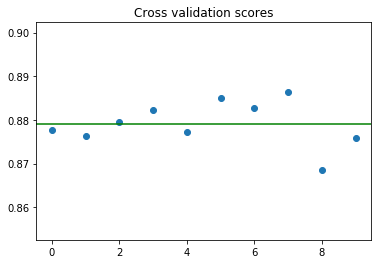


Test
Test Accuracy using vector tfidf_vector and model Naive-Bayes : 0.9193683155080213
Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     42989
           1       1.00      0.21      0.35      4883

    accuracy                           0.92     47872
   macro avg       0.96      0.60      0.65     47872
weighted avg       0.93      0.92      0.89     47872

Log loss: 0.30137277841892596
Confusion Matrix
        P No  P Yes
A No   42987      2
A Yes   3858   1025
Cross validation scores: [0.88584352 0.86943509 0.87845034 0.87564254 0.84197764 0.8600008
 0.88021971 0.86208716 0.86732046 0.87604973]


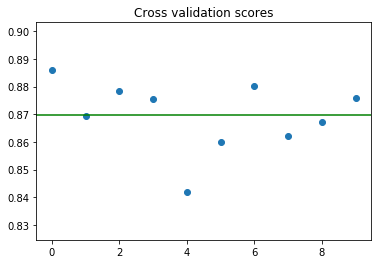

###########################################################

Using vector tfidf_vector and model Logit

Train
Train Accuracy using vector tfidf_vector and model Logit : 0.9596952524194488
Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    100357
           1       0.96      0.63      0.76     11342

    accuracy                           0.96    111699
   macro avg       0.96      0.81      0.87    111699
weighted avg       0.96      0.96      0.96    111699

Log loss: 0.10735412935207665
Confusion Matrix
         P No  P Yes
A No   100034    323
A Yes    4179   7163
Cross validation scores: [0.96528208 0.96763486 0.96401205 0.97009145 0.97040636 0.97289168
 0.96858703 0.96933565 0.96879108 0.96980524]


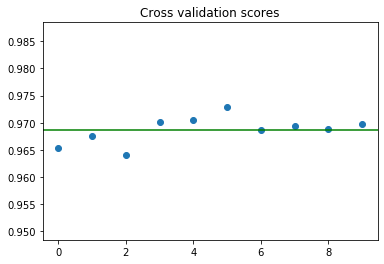


Test
Test Accuracy using vector tfidf_vector and model Logit : 0.9564045788770054
Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     42989
           1       0.94      0.61      0.74      4883

    accuracy                           0.96     47872
   macro avg       0.95      0.80      0.86     47872
weighted avg       0.96      0.96      0.95     47872

Log loss: 0.12212684886634283
Confusion Matrix
        P No  P Yes
A No   42784    205
A Yes   1882   3001
Cross validation scores: [0.9682168  0.95956543 0.96380759 0.96535889 0.95611732 0.96719834
 0.97086651 0.95445996 0.96659965 0.96285712]


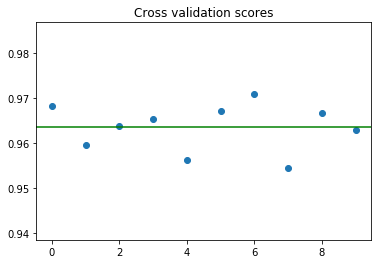

###########################################################

Using vector count_vector and model Naive-Bayes

Train
Train Accuracy using vector count_vector and model Naive-Bayes : 0.9534910787025846
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    100357
           1       0.81      0.70      0.75     11342

    accuracy                           0.95    111699
   macro avg       0.89      0.84      0.86    111699
weighted avg       0.95      0.95      0.95    111699

Log loss: 0.2969608358810793
Confusion Matrix
        P No  P Yes
A No   98511   1846
A Yes   3349   7993
Cross validation scores: [0.88988868 0.89433428 0.89589897 0.90413084 0.89686621 0.90350765
 0.90317999 0.90221147 0.88670069 0.89479169]


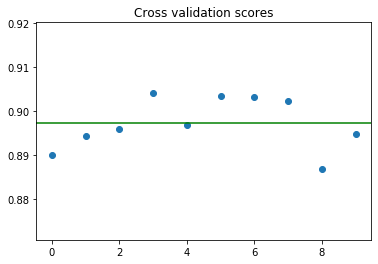


Test
Test Accuracy using vector count_vector and model Naive-Bayes : 0.9481534090909091
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     42989
           1       0.83      0.62      0.71      4883

    accuracy                           0.95     47872
   macro avg       0.89      0.80      0.84     47872
weighted avg       0.94      0.95      0.94     47872

Log loss: 0.39784657166148507
Confusion Matrix
        P No  P Yes
A No   42374    615
A Yes   1867   3016
Cross validation scores: [0.89839816 0.88050153 0.88725099 0.88922152 0.8547737  0.86691148
 0.90357675 0.86994712 0.8790874  0.89065157]


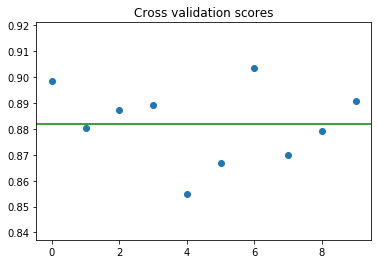

###########################################################

Using vector count_vector and model Logit


C:\Users\Rahmanfp\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Train
Train Accuracy using vector count_vector and model Logit : 0.9779317630417461
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    100357
           1       0.97      0.81      0.88     11342

    accuracy                           0.98    111699
   macro avg       0.97      0.90      0.93    111699
weighted avg       0.98      0.98      0.98    111699

Log loss: 0.06363040618534778
Confusion Matrix
         P No  P Yes
A No   100038    319
A Yes    2146   9196
Cross validation scores: [0.94952839 0.94782645 0.94371985 0.95184329 0.95089073 0.95825034
 0.95511208 0.95625149 0.950052   0.9502504 ]


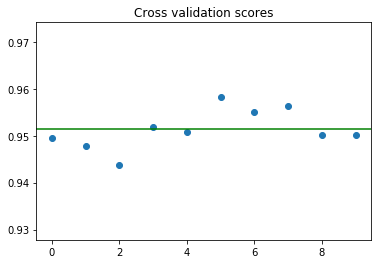


Test
Test Accuracy using vector count_vector and model Logit : 0.9564045788770054
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42989
           1       0.86      0.69      0.76      4883

    accuracy                           0.96     47872
   macro avg       0.91      0.84      0.87     47872
weighted avg       0.95      0.96      0.95     47872

Log loss: 0.15660733558392897
Confusion Matrix
        P No  P Yes
A No   42427    562
A Yes   1525   3358
Cross validation scores: [0.95930713 0.93510594 0.94362466 0.94710217 0.93848264 0.95278973
 0.9540455  0.93466885 0.95102368 0.94743881]


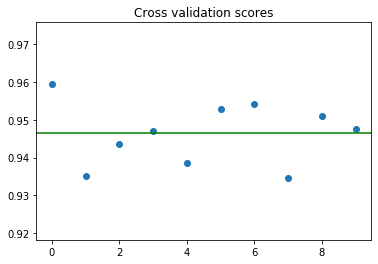

###########################################################


In [13]:
vector_model(hate_train['clean_text'], hate_test['clean_text'], label_train, label_test)

In [14]:
# Create a function to test which pair of vector and model that has the best evaluation score
def vector_model(X_train, X_test, y_train, y_test):
    
    vectorizer = {'tfidf_vector': TfidfVectorizer(), 'count_vector': CountVectorizer()}
    model = {'Naive-Bayes': MultinomialNB(), 'Logit': LogisticRegression()}
    
    add_info = ['exclamation', 'capital_word_percent', 'capital_letter_percent']
    
    for i,j in vectorizer.items():
        for k,l in model.items():            
            
            preprocess = ColumnTransformer(
                [('exclam', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['exclamation']),
                ('cwp', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['capital_word_percent']),
                ('clp', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['capital_letter_percent']),
                ('countvec', j, 'clean_text')],
                remainder='drop', n_jobs=-1)
        
            pipe_vm = Pipeline([('preprocess', preprocess), ('model', l)])
            
            print('\nUsing vector {} and model {}'.format(i,k))
            
            pipe_vm.fit(X_train, y_train)
            
            print('\nTrain')
            predict_train = pipe_vm.predict(X_train)
            predictProba_train = pipe_vm.predict_proba(X_train)
            print('Train Accuracy using vector {} and model {} : {}'.format(i,k,pipe_vm.score(X_train, y_train)))
            print('Classification Report')
            print(classification_report(y_train, predict_train))
            print('Log loss: {}'.format(log_loss(y_train, predictProba_train)))
            con = pd.DataFrame(data=confusion_matrix(y_train,predict_train), columns = ['P No', 'P Yes'], index = ['A No', 'A Yes'])
            print('Confusion Matrix')
            print(con)
            scores = cross_val_score(estimator=pipe_vm,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1,
                        scoring='roc_auc')
            print('Cross validation scores: {}'.format(scores))
            plt.title('Cross validation scores')
            plt.scatter(np.arange(len(scores)), scores)
            plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
            plt.show()
            
            print('\nTest')
            predict_test = pipe_vm.predict(X_test)
            predictProba_test = pipe_vm.predict_proba(X_test)
            print('Test Accuracy using vector {} and model {} : {}'.format(i,k,pipe_vm.score(X_test, y_test)))
            print('Classification Report')
            print(classification_report(y_test, predict_test))
            print('Log loss: {}'.format(log_loss(y_test, predictProba_test)))
            con = pd.DataFrame(data=confusion_matrix(y_test, predict_test), columns = ['P No', 'P Yes'], index = ['A No', 'A Yes'])
            print('Confusion Matrix')
            print(con)
            scores = cross_val_score(estimator=pipe_vm,
                        X=X_test,
                        y=y_test,
                        cv=10,
                        n_jobs=-1,
                        scoring='roc_auc')
            print('Cross validation scores: {}'.format(scores))
            plt.title('Cross validation scores')
            plt.scatter(np.arange(len(scores)), scores)
            plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
            plt.show()
            print('###########################################################')


Using vector tfidf_vector and model Naive-Bayes

Train
Train Accuracy using vector tfidf_vector and model Naive-Bayes : 0.9208766416888244
Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    100357
           1       0.94      0.24      0.38     11342

    accuracy                           0.92    111699
   macro avg       0.93      0.62      0.67    111699
weighted avg       0.92      0.92      0.90    111699

Log loss: 0.31480470173576436
Confusion Matrix
         P No  P Yes
A No   100182    175
A Yes    8663   2679
Cross validation scores: [0.89073577 0.88641631 0.88983056 0.89856016 0.89557145 0.89598627
 0.89517947 0.89459403 0.88441995 0.89297898]


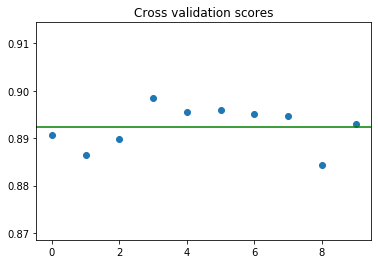


Test
Test Accuracy using vector tfidf_vector and model Naive-Bayes : 0.9137491644385026
Classification Report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     42989
           1       0.91      0.17      0.29      4883

    accuracy                           0.91     47872
   macro avg       0.91      0.58      0.62     47872
weighted avg       0.91      0.91      0.89     47872

Log loss: 0.402037050889791
Confusion Matrix
        P No  P Yes
A No   42911     78
A Yes   4051    832
Cross validation scores: [0.89635341 0.88663079 0.89922599 0.89171567 0.87046883 0.87829137
 0.8899737  0.88585246 0.88114611 0.89145092]


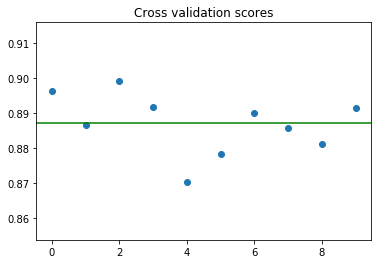

###########################################################

Using vector tfidf_vector and model Logit


C:\Users\Rahmanfp\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Train
Train Accuracy using vector tfidf_vector and model Logit : 0.9670005998263189
Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    100357
           1       0.97      0.69      0.81     11342

    accuracy                           0.97    111699
   macro avg       0.97      0.85      0.90    111699
weighted avg       0.97      0.97      0.96    111699

Log loss: 0.09091337524245624
Confusion Matrix
         P No  P Yes
A No   100138    219
A Yes    3467   7875
Cross validation scores: [0.96466548 0.96365711 0.96016519 0.96901121 0.97148221 0.97042455
 0.96654241 0.96671307 0.96707647 0.96873491]


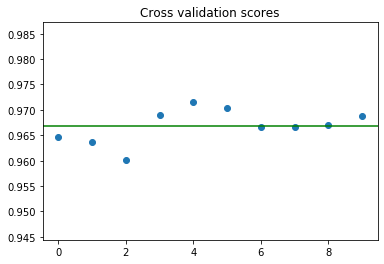


Test
Test Accuracy using vector tfidf_vector and model Logit : 0.9555063502673797
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     42989
           1       0.93      0.61      0.74      4883

    accuracy                           0.96     47872
   macro avg       0.94      0.80      0.86     47872
weighted avg       0.95      0.96      0.95     47872

Log loss: 0.12245099310621134
Confusion Matrix
        P No  P Yes
A No   42762    227
A Yes   1903   2980
Cross validation scores: [0.9610805  0.95412021 0.95882334 0.96026954 0.9537135  0.95757353
 0.96278037 0.95148819 0.96009604 0.95883138]


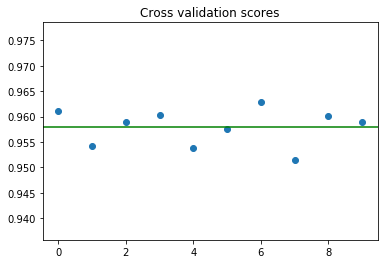

###########################################################

Using vector count_vector and model Naive-Bayes

Train
Train Accuracy using vector count_vector and model Naive-Bayes : 0.9521839944851789
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    100357
           1       0.80      0.71      0.75     11342

    accuracy                           0.95    111699
   macro avg       0.88      0.84      0.86    111699
weighted avg       0.95      0.95      0.95    111699

Log loss: 0.30978980430872544
Confusion Matrix
        P No  P Yes
A No   98358   1999
A Yes   3342   8000
Cross validation scores: [0.88392071 0.88745182 0.88958049 0.89911029 0.89194218 0.8967338
 0.89847124 0.89614539 0.88119279 0.88762589]


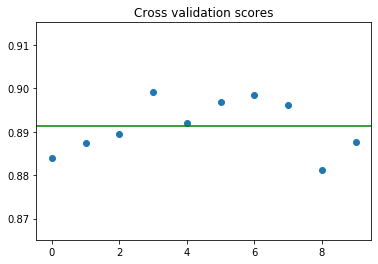


Test
Test Accuracy using vector count_vector and model Naive-Bayes : 0.9453542780748663
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     42989
           1       0.81      0.60      0.69      4883

    accuracy                           0.95     47872
   macro avg       0.88      0.79      0.83     47872
weighted avg       0.94      0.95      0.94     47872

Log loss: 0.43915369841941737
Confusion Matrix
        P No  P Yes
A No   42305    684
A Yes   1932   2951
Cross validation scores: [0.89184054 0.87633877 0.88423156 0.8846055  0.84988551 0.86050654
 0.89718372 0.86482369 0.87461581 0.8866282 ]


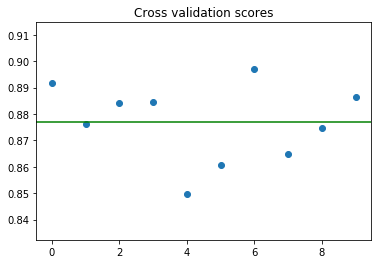

###########################################################

Using vector count_vector and model Logit


C:\Users\Rahmanfp\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Train
Train Accuracy using vector count_vector and model Logit : 0.9803758314756623
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    100357
           1       0.97      0.83      0.90     11342

    accuracy                           0.98    111699
   macro avg       0.98      0.91      0.94    111699
weighted avg       0.98      0.98      0.98    111699

Log loss: 0.05774315077725666
Confusion Matrix
         P No  P Yes
A No   100064    293
A Yes    1899   9443
Cross validation scores: [0.95253252 0.94942598 0.94449708 0.95301693 0.95466963 0.95786869
 0.95652933 0.95731407 0.9498304  0.95267955]


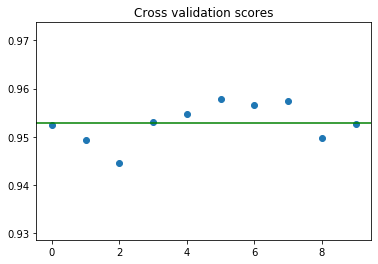


Test
Test Accuracy using vector count_vector and model Logit : 0.9565925802139037
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42989
           1       0.85      0.69      0.77      4883

    accuracy                           0.96     47872
   macro avg       0.91      0.84      0.87     47872
weighted avg       0.95      0.96      0.95     47872

Log loss: 0.15615197407577666
Confusion Matrix
        P No  P Yes
A No   42411    578
A Yes   1500   3383
Cross validation scores: [0.9585094  0.93535283 0.94564548 0.94830765 0.9413984  0.95304283
 0.9542743  0.93725309 0.95226301 0.94681361]


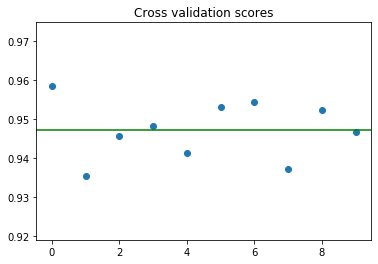

###########################################################


In [15]:
vector_model(hate_train, hate_test, label_train, label_test)

- Best Vectorizer = CountVectorizer
- Best Model = Logistic Regression

In [16]:
# Create a function to find best parameter based on a random cross validation
def random_vect(parameters_model, X_train, X_test, y_train, y_test, parameters_text):
    
    add_info = ['exclamation', 'capital_word_percent', 'capital_letter_percent']
    
    preprocess = ColumnTransformer(
                [('exclam', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['exclamation']),
                ('cwp', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['capital_word_percent']),
                ('clp', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['capital_letter_percent']),
                ('vect', CountVectorizer(), 'clean_text')],
                remainder='drop', n_jobs=-1)
        
    pipe_vm = Pipeline([('preprocess', preprocess), ('model', LogisticRegression(n_jobs=-1))])
    
    # Join the parameters dictionaries together
    parameters = dict()
    parameters.update(parameters_text)
    parameters.update(parameters_model)
    
    random_search = RandomizedSearchCV(pipe_vm, parameters, n_jobs=-1, verbose=1, cv=5, n_iter=10)
    
    print("Performing random search...")
    print("pipeline:", [name for name, _ in pipe_vm.steps])
    print("parameters:")
    pprint(parameters)
    random_search.fit(X_train, y_train)
    print("Best CV score: %0.3f" % random_search.best_score_)
    print("Best parameters set:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % random_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, random_search.best_estimator_.predict(X_test)))
    scores = cross_val_score(estimator=random_search.best_estimator_,
                X=X_test,
                y=y_test,
                cv=10,
                n_jobs=-1,
                scoring='roc_auc')
    print('Cross validation scores: {}'.format(scores))
    plt.title('Cross validation scores')
    plt.scatter(np.arange(len(scores)), scores)
    plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
    plt.show()
    return random_search

In [17]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
    'preprocess__vect__ngram_range': ((1,1), (1,2), (1,3), (1,4)),
    'preprocess__vect__min_df': (10,20,50,75,100),
    'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000)}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'model__C': (0.001, 0.01, 0.1, 1.0),
    'model__penalty': ('l1', 'l2'),
    'model__max_iter': (100, 500, 1000)}

##### Min_df
Min_df ignores terms that have a document frequency (presence in % of documents) strictly lower than the given threshold. For example, Min_df=0.66 requires that a term appear in 66% of the docuemnts for it to be considered part of the vocabulary.

##### Max_df
When building the vocabulary, it ignores terms that have a document frequency strictly higher than the given threshold. This could be used to exclude terms that are too frequent and are unlikely to help predict the label. For example, by analyzing reviews on the movie Lion King, the term 'Lion' might appear in 90% of the reviews (documents), in which case, we could consider establishing Max_df=0.89

##### Max_features
Limit the amount of features (vocabulary) that the vectorizer will learn

##### Regularization
1. L1 Regularization (Lasso Regression) -> Data yang dianggap tidak penting didekatkan ke nol
2. L2 Regularization (Ridge Regression) -> Data yang dianggap tidak penting bisa jadi nol

##### C 
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

################################################################
Iterasi: 1
Performing random search...
pipeline: ['preprocess', 'model']
parameters:
{'model__C': (0.001, 0.01, 0.1, 1.0),
 'model__max_iter': (100, 500, 1000),
 'model__penalty': ('l1', 'l2'),
 'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
 'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20, 50, 75, 100),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.5min finished


Best CV score: 0.955
Best parameters set:
	model__C: 1.0
	model__max_iter: 1000
	model__penalty: 'l2'
	preprocess__vect__max_df: 0.75
	preprocess__vect__max_features: 30000
	preprocess__vect__min_df: 20
	preprocess__vect__ngram_range: (1, 4)
Test score with best_estimator_: 0.956


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42989
           1       0.86      0.69      0.76      4883

    accuracy                           0.96     47872
   macro avg       0.91      0.84      0.87     47872
weighted avg       0.95      0.96      0.95     47872

Cross validation scores: [0.95179123 0.93133277 0.94052229 0.94215582 0.938741   0.94453247
 0.94670868 0.93354583 0.94346474 0.93807625]


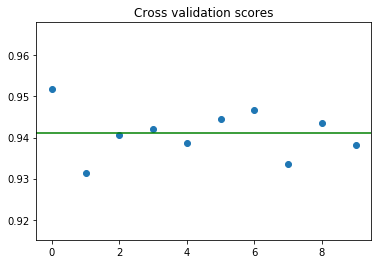

################################################################
Iterasi: 2
Performing random search...
pipeline: ['preprocess', 'model']
parameters:
{'model__C': (0.001, 0.01, 0.1, 1.0),
 'model__max_iter': (100, 500, 1000),
 'model__penalty': ('l1', 'l2'),
 'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
 'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20, 50, 75, 100),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.5min finished


Best CV score: 0.956
Best parameters set:
	model__C: 1.0
	model__max_iter: 1000
	model__penalty: 'l2'
	preprocess__vect__max_df: 0.25
	preprocess__vect__max_features: 40000
	preprocess__vect__min_df: 10
	preprocess__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.956


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42989
           1       0.85      0.69      0.76      4883

    accuracy                           0.96     47872
   macro avg       0.91      0.84      0.87     47872
weighted avg       0.95      0.96      0.95     47872

Cross validation scores: [0.95648296 0.93394574 0.94285842 0.94336607 0.93965381 0.94913705
 0.94950146 0.93701905 0.94936871 0.94360934]


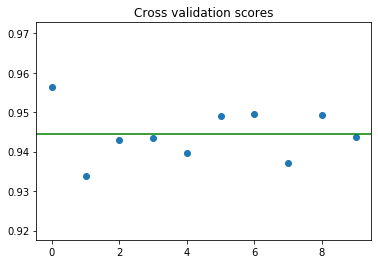

################################################################
Iterasi: 3
Performing random search...
pipeline: ['preprocess', 'model']
parameters:
{'model__C': (0.001, 0.01, 0.1, 1.0),
 'model__max_iter': (100, 500, 1000),
 'model__penalty': ('l1', 'l2'),
 'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
 'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20, 50, 75, 100),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.1min finished


Best CV score: 0.951
Best parameters set:
	model__C: 1.0
	model__max_iter: 1000
	model__penalty: 'l2'
	preprocess__vect__max_df: 0.75
	preprocess__vect__max_features: 20000
	preprocess__vect__min_df: 100
	preprocess__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.952


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     42989
           1       0.84      0.65      0.74      4883

    accuracy                           0.95     47872
   macro avg       0.90      0.82      0.85     47872
weighted avg       0.95      0.95      0.95     47872

Cross validation scores: [0.92910512 0.90779945 0.92640659 0.92227343 0.90552511 0.92544969
 0.91802874 0.92150553 0.92268169 0.9167397 ]


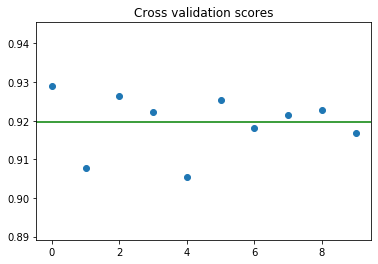

################################################################
Iterasi: 4
Performing random search...
pipeline: ['preprocess', 'model']
parameters:
{'model__C': (0.001, 0.01, 0.1, 1.0),
 'model__max_iter': (100, 500, 1000),
 'model__penalty': ('l1', 'l2'),
 'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
 'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20, 50, 75, 100),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.7min finished


Best CV score: 0.953
Best parameters set:
	model__C: 1.0
	model__max_iter: 500
	model__penalty: 'l2'
	preprocess__vect__max_df: 1.0
	preprocess__vect__max_features: 30000
	preprocess__vect__min_df: 50
	preprocess__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.955


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     42989
           1       0.85      0.68      0.75      4883

    accuracy                           0.95     47872
   macro avg       0.91      0.83      0.86     47872
weighted avg       0.95      0.95      0.95     47872

Cross validation scores: [0.93836109 0.92274491 0.93303437 0.93169613 0.92648786 0.93604284
 0.93315473 0.92713303 0.93602878 0.93059073]


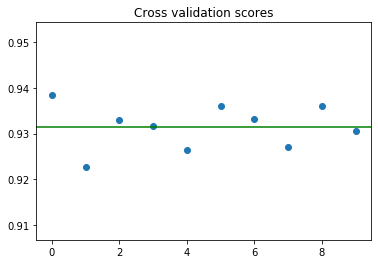

################################################################
Iterasi: 5
Performing random search...
pipeline: ['preprocess', 'model']
parameters:
{'model__C': (0.001, 0.01, 0.1, 1.0),
 'model__max_iter': (100, 500, 1000),
 'model__penalty': ('l1', 'l2'),
 'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
 'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20, 50, 75, 100),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.7min finished


Best CV score: 0.954
Best parameters set:
	model__C: 1.0
	model__max_iter: 100
	model__penalty: 'l2'
	preprocess__vect__max_df: 1.0
	preprocess__vect__max_features: 10000
	preprocess__vect__min_df: 20
	preprocess__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.955


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     42989
           1       0.85      0.68      0.76      4883

    accuracy                           0.96     47872
   macro avg       0.91      0.83      0.87     47872
weighted avg       0.95      0.96      0.95     47872

Cross validation scores: [0.95230926 0.93091559 0.93882727 0.94131737 0.93895883 0.94365922
 0.94660286 0.93375509 0.94285461 0.93784882]


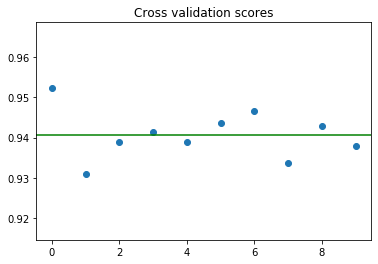

################################################################
Iterasi: 6
Performing random search...
pipeline: ['preprocess', 'model']
parameters:
{'model__C': (0.001, 0.01, 0.1, 1.0),
 'model__max_iter': (100, 500, 1000),
 'model__penalty': ('l1', 'l2'),
 'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
 'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20, 50, 75, 100),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.5min finished


Best CV score: 0.953
Best parameters set:
	model__C: 1.0
	model__max_iter: 500
	model__penalty: 'l2'
	preprocess__vect__max_df: 0.25
	preprocess__vect__max_features: 40000
	preprocess__vect__min_df: 50
	preprocess__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.955


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     42989
           1       0.85      0.68      0.75      4883

    accuracy                           0.95     47872
   macro avg       0.91      0.83      0.86     47872
weighted avg       0.95      0.95      0.95     47872

Cross validation scores: [0.9383549  0.92276061 0.93301292 0.93169065 0.92649739 0.93603092
 0.9331502  0.92719189 0.93606453 0.93059881]


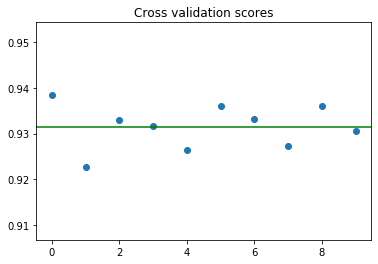

################################################################
Iterasi: 7
Performing random search...
pipeline: ['preprocess', 'model']
parameters:
{'model__C': (0.001, 0.01, 0.1, 1.0),
 'model__max_iter': (100, 500, 1000),
 'model__penalty': ('l1', 'l2'),
 'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
 'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20, 50, 75, 100),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.0min finished


Best CV score: 0.934
Best parameters set:
	model__C: 0.01
	model__max_iter: 1000
	model__penalty: 'l2'
	preprocess__vect__max_df: 0.25
	preprocess__vect__max_features: 40000
	preprocess__vect__min_df: 100
	preprocess__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.937


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     42989
           1       0.94      0.41      0.57      4883

    accuracy                           0.94     47872
   macro avg       0.94      0.70      0.77     47872
weighted avg       0.94      0.94      0.93     47872

Cross validation scores: [0.9256754  0.90967653 0.92740806 0.91832832 0.90579681 0.92410287
 0.92069543 0.91289125 0.92194525 0.92432206]


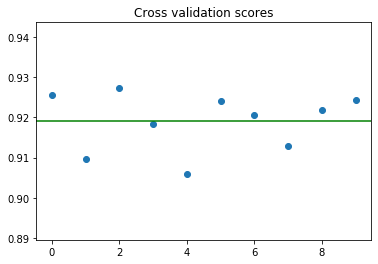

################################################################
Iterasi: 8
Performing random search...
pipeline: ['preprocess', 'model']
parameters:
{'model__C': (0.001, 0.01, 0.1, 1.0),
 'model__max_iter': (100, 500, 1000),
 'model__penalty': ('l1', 'l2'),
 'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
 'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20, 50, 75, 100),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.5min finished


Best CV score: 0.956
Best parameters set:
	model__C: 1.0
	model__max_iter: 1000
	model__penalty: 'l2'
	preprocess__vect__max_df: 0.25
	preprocess__vect__max_features: 50000
	preprocess__vect__min_df: 10
	preprocess__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.957


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42989
           1       0.86      0.69      0.77      4883

    accuracy                           0.96     47872
   macro avg       0.91      0.84      0.87     47872
weighted avg       0.95      0.96      0.95     47872

Cross validation scores: [0.95435901 0.93672662 0.94554204 0.94654924 0.94003371 0.95136116
 0.95015782 0.93810679 0.94969713 0.94395905]


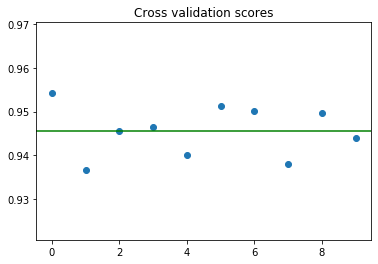

################################################################
Iterasi: 9
Performing random search...
pipeline: ['preprocess', 'model']
parameters:
{'model__C': (0.001, 0.01, 0.1, 1.0),
 'model__max_iter': (100, 500, 1000),
 'model__penalty': ('l1', 'l2'),
 'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
 'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20, 50, 75, 100),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.3min finished


Best CV score: 0.953
Best parameters set:
	model__C: 1.0
	model__max_iter: 1000
	model__penalty: 'l2'
	preprocess__vect__max_df: 0.5
	preprocess__vect__max_features: 20000
	preprocess__vect__min_df: 50
	preprocess__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.955


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     42989
           1       0.85      0.68      0.75      4883

    accuracy                           0.95     47872
   macro avg       0.91      0.83      0.86     47872
weighted avg       0.95      0.95      0.95     47872

Cross validation scores: [0.93835633 0.92279819 0.93321312 0.93121995 0.92649501 0.9359885
 0.93353892 0.92721978 0.93605499 0.9304399 ]


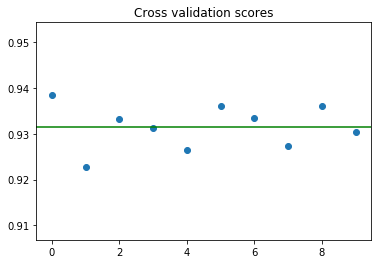

################################################################
Iterasi: 10
Performing random search...
pipeline: ['preprocess', 'model']
parameters:
{'model__C': (0.001, 0.01, 0.1, 1.0),
 'model__max_iter': (100, 500, 1000),
 'model__penalty': ('l1', 'l2'),
 'preprocess__vect__max_df': (0.25, 0.5, 0.75, 1.0),
 'preprocess__vect__max_features': (10000, 20000, 30000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20, 50, 75, 100),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4))}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.9min finished


Best CV score: 0.953
Best parameters set:
	model__C: 1.0
	model__max_iter: 1000
	model__penalty: 'l2'
	preprocess__vect__max_df: 0.5
	preprocess__vect__max_features: 40000
	preprocess__vect__min_df: 50
	preprocess__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.955


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     42989
           1       0.85      0.68      0.75      4883

    accuracy                           0.95     47872
   macro avg       0.91      0.83      0.86     47872
weighted avg       0.95      0.95      0.95     47872

Cross validation scores: [0.93836109 0.92274491 0.93303437 0.93169613 0.92648786 0.93604284
 0.93315473 0.92713303 0.93602878 0.93059073]


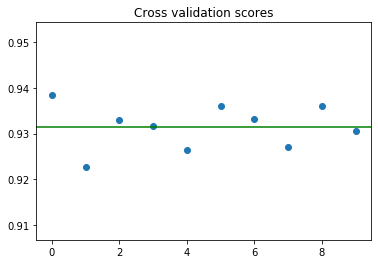

In [18]:
for i in range(10):
    print('################################################################')
    print('Iterasi: {}'.format(i+1))
    random_vect(parameters_logreg, hate_train, hate_test, label_train, label_test, parameters_vect)

In [20]:
# Create a function to find best parameter based on a grid cross validation
def grid_vect(parameters_model, X_train, X_test, y_train, y_test, parameters_text):
    
    add_info = ['exclamation', 'capital_word_percent', 'capital_letter_percent']
    
    preprocess = ColumnTransformer(
                [('exclam', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['exclamation']),
                ('cwp', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['capital_word_percent']),
                ('clp', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['capital_letter_percent']),
                ('vect', CountVectorizer(), 'clean_text')],
                remainder='drop', n_jobs=-1)
        
    pipe_vm = Pipeline([('preprocess', preprocess), ('model', LogisticRegression(n_jobs=-1))])
    
    # Join the parameters dictionaries together
    parameters = dict()
    parameters.update(parameters_text)
    parameters.update(parameters_model)
    grid_search = GridSearchCV(pipe_vm, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipe_vm.steps])
    print("parameters:")
    pprint(parameters)
    grid_search.fit(X_train, y_train)
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    scores = cross_val_score(estimator=grid_search.best_estimator_,
                X=X_test,
                y=y_test,
                cv=10,
                n_jobs=-1,
                scoring='roc_auc')
    print('Cross validation scores: {}'.format(scores))
    plt.title('Cross validation scores')
    plt.scatter(np.arange(len(scores)), scores)
    plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
    plt.show()
    return grid_search

In [21]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'preprocess__vect__max_df': (0.25, 0.5, 1.00),
    'preprocess__vect__ngram_range': ((1,1), (1,2), (1,4)),
    'preprocess__vect__min_df': (10, 20),
    'preprocess__vect__max_features': (20000, 40000, 50000)}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
#     'model__C': (1.0),
#     'model__penalty': ('l2'),
    'model__max_iter': (500, 1000)}

Performing grid search...
pipeline: ['preprocess', 'model']
parameters:
{'model__max_iter': (500, 1000),
 'preprocess__vect__max_df': (0.25, 0.5, 1.0),
 'preprocess__vect__max_features': (20000, 40000, 50000),
 'preprocess__vect__min_df': (10, 20),
 'preprocess__vect__ngram_range': ((1, 1), (1, 2), (1, 4))}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 74.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 91.8min finished


Best CV score: 0.956
Best parameters set:
	model__max_iter: 500
	preprocess__vect__max_df: 0.25
	preprocess__vect__max_features: 50000
	preprocess__vect__min_df: 10
	preprocess__vect__ngram_range: (1, 4)
Test score with best_estimator_: 0.957


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42989
           1       0.86      0.69      0.77      4883

    accuracy                           0.96     47872
   macro avg       0.91      0.84      0.87     47872
weighted avg       0.96      0.96      0.96     47872

Cross validation scores: [0.95462825 0.93693973 0.94570745 0.94601585 0.9404322  0.95064807
 0.94998384 0.93819021 0.95001268 0.94376302]


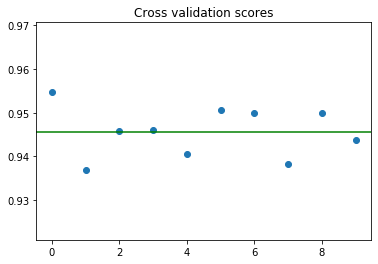

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('exclam',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype='int',
                                                                                       handle_unknown='ignore',
                                                         

In [22]:
grid_vect(parameters_logreg, hate_train, hate_test, label_train, label_test, parameters_vect)

In [23]:
preprocess = ColumnTransformer(
                [('exclam', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['exclamation']),
                ('cwp', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['capital_word_percent']),
                ('clp', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['capital_letter_percent']),
                ('vect', CountVectorizer(max_df=0.25, max_features=50000, min_df=10, ngram_range=(1,4)), 'clean_text')],
                remainder='drop', n_jobs=-1)
        
pipe_vm = Pipeline([('preprocess', preprocess), ('model', LogisticRegression(n_jobs=-1, max_iter=500))])

In [24]:
pipe_vm.fit(hate_train, label_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('exclam',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['exclamation']),
                                                 ('cwp',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                    

In [29]:
def try_model(text):
    df_trial = pd.DataFrame(data=text, columns = ['comment_text'], index=[0])
    
    inside_info(df_trial)
    df_trial['clean_text'] = df_trial['comment_text'].apply(clean)
    df_trial = df_trial[['comment_text', 'exclamation', 'capital_word_percent', 'capital_letter_percent', 'clean_text']]
    
    Predict = pipe_vm.predict(df_trial)
    print(Predict)
    PredictProb = pipe_vm.predict_proba(df_trial)
    print(PredictProb)
        
    if PredictProb[0][0] > 0.5:
        x = print('That comment is not a hate speech with probability of {} %'.format(PredictProb[0][0]*100))
    else:
        x = print('That comment is a hate speech with probability of {} %'.format(PredictProb[0][1]*100))
    return x

In [33]:
try_model('you are good')

[0]
[[0.94003597 0.05996403]]
That comment is not a hate speech with probability of 94.0035971024235 %


In [32]:
import pickle
filename = 'hate_model.sav';
pickle.dump(pipe_vm, open(filename, 'wb'))